# Time Series Prediction with Convolutional Neural Networks ($CNN$)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Gathering Dependencies

_Importing Required Libraries_

In [2]:
pip install hampel

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from keras.models import Sequential
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
import keras
import tensorflow as tf
from hampel import hampel
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from numpy import array

## Loading Datasets

_El NINO_

In [36]:
data = pd.read_csv("/content/drive/MyDrive/new/datasets/elnino.csv")
training_set = data.iloc[:, 1]
print(training_set)

<bound method NDFrame.head of            Name  Station Time(norwegian mean time)  Precipitation (24 h)
0      Bjørnøya  SN99710                16.06.1980                   0.0
1      Bjørnøya  SN99710                17.06.1980                   0.1
2      Bjørnøya  SN99710                18.06.1980                   0.0
3      Bjørnøya  SN99710                19.06.1980                   0.0
4      Bjørnøya  SN99710                20.06.1980                   1.9
...         ...      ...                       ...                   ...
15315  Bjørnøya  SN99710                11.06.2022                   0.0
15316  Bjørnøya  SN99710                12.06.2022                   0.0
15317  Bjørnøya  SN99710                13.06.2022                   0.0
15318  Bjørnøya  SN99710                15.06.2022                   0.0
15319  Bjørnøya  SN99710                16.06.2022                   0.0

[15320 rows x 4 columns]>


## Preprocessing the Data

In [37]:
# univariate data preparation
from numpy import array

# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

# choose a number of time steps
n_steps = 3
# split into samples
X, y = split_sequence(training_set, n_steps)
# summarize the data
for i in range(len(X)):
	print(X[i], y[i])

Streaming output truncated to the last 5000 lines.
[0.4 0.6 0.2] 4.5
[0.6 0.2 4.5] 0.4
[0.2 4.5 0.4] 0.6
[4.5 0.4 0.6] 1.5
[0.4 0.6 1.5] 4.1
[0.6 1.5 4.1] 2.2
[1.5 4.1 2.2] 1.0
[4.1 2.2 1. ] 0.6
[2.2 1.  0.6] 0.8
[1.  0.6 0.8] 0.6
[0.6 0.8 0.6] 4.5
[0.8 0.6 4.5] 0.2
[0.6 4.5 0.2] 0.0
[4.5 0.2 0. ] 0.0
[0.2 0.  0. ] 0.8
[0.  0.  0.8] 0.4
[0.  0.8 0.4] 0.0
[0.8 0.4 0. ] 0.2
[0.4 0.  0.2] 0.0
[0.  0.2 0. ] 0.0
[0.2 0.  0. ] 0.2
[0.  0.  0.2] 0.0
[0.  0.2 0. ] 0.0
[0.2 0.  0. ] 0.0
[0. 0. 0.] 0.4
[0.  0.  0.4] 1.4
[0.  0.4 1.4] 0.0
[0.4 1.4 0. ] 0.0
[1.4 0.  0. ] 0.0
[0. 0. 0.] 0.0
[0. 0. 0.] 0.0
[0. 0. 0.] 0.0
[0. 0. 0.] 0.0
[0. 0. 0.] 0.9
[0.  0.  0.9] 0.6
[0.  0.9 0.6] 0.0
[0.9 0.6 0. ] 0.2
[0.6 0.  0.2] 0.0
[0.  0.2 0. ] 8.0
[0.2 0.  8. ] 0.2
[0.  8.  0.2] 0.0
[8.  0.2 0. ] 0.0
[0.2 0.  0. ] 0.8
[0.  0.  0.8] 0.0
[0.  0.8 0. ] 0.4
[0.8 0.  0.4] 2.0
[0.  0.4 2. ] 3.3
[0.4 2.  3.3] 0.6
[2.  3.3 0.6] 0.0
[3.3 0.6 0. ] 0.2
[0.6 0.  0.2] 0.0
[0.  0.2 0. ] 0.8
[0.2 0.  0.8] 1.0
[0.  0.8 1. ]

## Train and Test Split

In [38]:
train_size = int(len(y) * 0.8)
test_size = len(y) - train_size
dataX = np.array(X)
dataY = np.array(y)
trainX = np.array(X[0:train_size])
trainY = np.array(y[0:train_size])
testX = np.array(X[train_size:len(X)])
testY = np.array(y[train_size:len(y)])
trainX = trainX.reshape((trainX.shape[0], 1, trainX.shape[1]))
testX = testX.reshape((testX.shape[0], 1, testX.shape[1]))
print(trainX.shape, trainY.shape, testX.shape, testY.shape)

(12253, 1, 3) (12253,) (3064, 1, 3) (3064,)


## Model ($CNN$)

In [39]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)
 
n_steps = 3
# split into samples
X, y = split_sequence(training_set, n_steps)
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
# define model
# model = Sequential()
# model.add(LSTM(50, activation='relu', input_shape=(3, n_features)))
# model.add(Dense(1))
# model.compile(optimizer='adam', loss='mse')

model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, n_steps, n_features)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
# fit network
history = model.fit(trainX, trainY, epochs=500, batch_size=64, validation_data=(testX, testY), verbose=1, shuffle=False)

# # fit model
# history = model.fit(X, y,epochs=50)

Epoch 1/500
192/192 [==============================] - 3s 8ms/step - loss: 6.0250 - val_loss: 6.8006
Epoch 2/500
192/192 [==============================] - 1s 7ms/step - loss: 5.6486 - val_loss: 6.7635
Epoch 3/500
192/192 [==============================] - 2s 12ms/step - loss: 5.6380 - val_loss: 6.7669
Epoch 4/500
192/192 [==============================] - 2s 10ms/step - loss: 5.6362 - val_loss: 6.7690
Epoch 5/500
192/192 [==============================] - 2s 10ms/step - loss: 5.6355 - val_loss: 6.7700
Epoch 6/500
192/192 [==============================] - 2s 12ms/step - loss: 5.6350 - val_loss: 6.7703
Epoch 7/500
192/192 [==============================] - 1s 6ms/step - loss: 5.6346 - val_loss: 6.7705
Epoch 8/500
192/192 [==============================] - 1s 7ms/step - loss: 5.6345 - val_loss: 6.7705
Epoch 9/500
192/192 [==============================] - 1s 6ms/step - loss: 5.6340 - val_loss: 6.7705
Epoch 10/500
192/192 [==============================] - 1s 7ms/step - loss: 5.6343 - va

## Metrics ($CNN$)

In [40]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
yhat = model.predict(testX, verbose=0)
rmse = np.sqrt(mean_squared_error(testY, yhat))
mae = np.sqrt(mean_absolute_error(testY, yhat))
print('Test RMSE: %.3f' % rmse)
print('Test MAE: %.3f' % mae)

Test RMSE: 2.601
Test MAE: 1.205


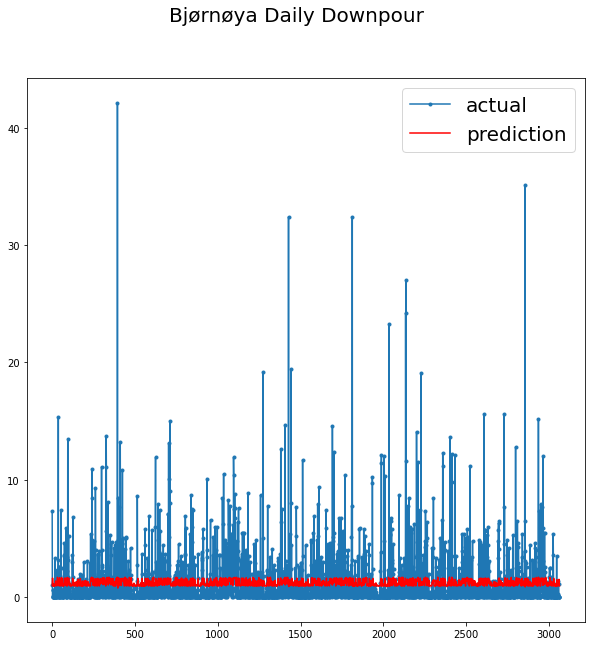

In [42]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = [10, 10] # for square canvas
anurag=[x for x in range(325)]
plt.plot(anurag, testY[:325], marker='.', label="actual")
plt.plot(anurag, yhat[:325], 'r', label="prediction")
plt.suptitle('El Niño Surface Temperature of the Sea')
plt.legend(fontsize=13)
plt.show()